# Imports & dependencies

In [1]:
# Note: I took the dataset taxi_data.h5 from Baidu

In [2]:
xx=40;

In [3]:
# Date: March-2nd-2023
# Description: This source code creates hetergogenous graphs for taxi deamnd and supply prediciton 
# (with 3 edge types) and then uses them to train and test with GNN and LSTM models for predicting the demand 
# and suply values
# by: Mahmoud Nazzal

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch_geometric.transforms as T
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear
import torch.optim as optim
import networkx as nx
from torch_geometric.data import HeteroData
import numpy.matlib
from scipy.linalg import block_diag
import copy
# # resources:
# 1.https://pytorch-geometric.readthedocs.io/en/2.0.0/notes/heterogeneous.html?highlight=HeteroGNN#using-the-heterogenous-convolution-wrapper 
# 2.https://levelup.gitconnected.com/forecasting-walmart-quarterly-revenue-pytorch-lstm-example-b4e4b20862a7

In [5]:
# this routine converts adjacency matrices into adjacency lists
def A_to_edge_index(A):
    G=nx.from_numpy_matrix(A)
    edge_index=list(G.edges)
    z=torch.tensor(np.transpose(edge_index))
    return z

In [6]:
# if a GPU is aviaable, use it, o.w., use the CPU
cuda_device = 0
if torch.cuda.is_available():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.set_device(cuda_device)

# Reading the data

In [ ]:
import pandas as pd
import numpy as np
# 1. load the data from the pytorch files:
# adj=torch.load('adj.pt')
# adj2=adj[2]
adj_0=torch.load('adj_0.pt')
adj_1=torch.load('adj_1.pt')
adj_2=torch.load('adj_2.pt')

# adj_0=adj_0[0:10, 0:10]
# adj_1=adj_1[0:10, 0:10]
# adj_2=adj_2[0:10, 0:10]

# 2. convert the adj  matrixes to adjacency lists
edge_list0=A_to_edge_index(adj_0)
edge_list1=A_to_edge_index(adj_1)
edge_list2=A_to_edge_index(adj_2)
# 3. load the training and testing node feature matrices
data0=torch.load('data0.pt')
data1=torch.load('data1.pt')
X_train_new=torch.load('X_train_new.pt')
X_test_new=torch.load('X_test_new.pt')
# print(X_train_new.shape)
# print(X_test_new.shape)

In [ ]:
print(adj_0)

In [ ]:
# X_train_new=X_train_new[0:10,:,:]
# X_test_new=X_test_new[0:10,:,:]

print(X_train_new.shape)
print(X_test_new.shape)

In [ ]:
# obtain data for the cars in the first 10 regions
arrz=[]
for kk in range(100):
    arr = np.empty((0,216))
    arr_tru=np.empty((0,216))
    t_s=kk
    for i in range(xx):
        n_nodes_in_reg=np.sum(data1[t_s, i])

        message_nodes_in_reg=X_train_new[i,:, t_s]
        X_temp=np.matlib.repmat(message_nodes_in_reg, n_nodes_in_reg, 1)
        arr = np.vstack((arr, X_temp))

        message_nodes_in_reg_tru=X_train_new[i,:,t_s+1]
        X_temp2=np.matlib.repmat(message_nodes_in_reg_tru, n_nodes_in_reg, 1)
        arr_tru = np.vstack((arr_tru, X_temp2))

    # X=np.asarray(X)   
#     print(arr.shape)
    arrz.append(arr.shape[0])
#     print(arr_tru.shape)   

In [ ]:
# obtain adj info for the cars in the first 10 regions
t_s=100
n_nodes_in_reg_list=[]
A = np.empty((0,0))
for i in range(xx):
        n_nodes_in_reg=np.sum(data1[t_s, i])
        block=np.matlib.repmat(adj_0[i,i], n_nodes_in_reg, n_nodes_in_reg);
        A=block_diag(A, block)
A=A.astype(float)       
print(A.shape)

edge_list0=A_to_edge_index(A)
print(edge_list0.shape)

In [ ]:
# print(A[0:10,0:500])

In [ ]:
def get_graph_per_ts(t_s):
# obtain data for the cars in the first 10 regions
    arr = np.empty((0,216))
    arr_tru=np.empty((0,216))
#     t_s=0
    for i in range(xx):
        n_nodes_in_reg=np.sum(data1[t_s, i])

        message_nodes_in_reg=X_train_new[i,:, t_s]
        X_temp=np.matlib.repmat(message_nodes_in_reg, n_nodes_in_reg, 1)
        arr = np.vstack((arr, X_temp))

        message_nodes_in_reg_tru=X_train_new[i,:,t_s+1]
        X_temp2=np.matlib.repmat(message_nodes_in_reg_tru, n_nodes_in_reg, 1)
        arr_tru = np.vstack((arr_tru, X_temp2))

    # X=np.asarray(X)   
#     print(arr.shape)
#     print(arr_tru.shape)  


    # obtain adj info for the cars in the first 10 regions
#     t_s=0
    n_nodes_in_reg_list=[]
    A0 = np.empty((0,0))
    A1 = np.empty((0,0))
    A2 = np.empty((0,0))
    for i in range(xx):
            n_nodes_in_reg=np.sum(data1[t_s, i])
            block0=np.matlib.repmat(adj_0[i,i], n_nodes_in_reg, n_nodes_in_reg);
            A0=block_diag(A0, block0)
            
            block1=np.matlib.repmat(adj_0[i,i], n_nodes_in_reg, n_nodes_in_reg);
            A1=block_diag(A1, block1)
            
            block2=np.matlib.repmat(adj_0[i,i], n_nodes_in_reg, n_nodes_in_reg);
            A2=block_diag(A2, block2)
    
#     A0=A0.astype(float) 
#     print(A.shape)

    edge_list0=A_to_edge_index(A0)
    edge_list1=A_to_edge_index(A1)
    edge_list2=A_to_edge_index(A2)
#     print(edge_list0.shape)
#     print(edge_list1.shape)
#     print(edge_list2.shape)
    data = HeteroData()
    
    
    arr=torch.from_numpy(arr)
    mean1, std1 =arr.mean(axis=0), arr.std(axis=0)
    data['taxi'].x =  (arr - mean1) / std1
    
    
    arr_tru=torch.from_numpy(arr_tru)
    mean2, std2 =arr_tru.mean(axis=0), arr_tru.std(axis=0)
    data['taxi'].y =  (arr_tru - mean2) / std2
    
    
#     data['taxi'].x= arr
    data['taxi', 'near', 'taxi'].edge_index = edge_list0
    data['taxi', 'connected', 'taxi'].edge_index = edge_list1
    data['taxi', 'OD_similar', 'taxi'].edge_index = edge_list2
    temp=np.array([True])
    temp2=np.tile(temp, 266)
    data['taxi'].test_mask=torch.from_numpy(temp2)
#     data['taxi'].y=torch.from_numpy(arr_tru)
    return data

In [ ]:
data=get_graph_per_ts(0)

In [ ]:
print(data.edge_index_dict)

In [ ]:
# verify the graph properties
print(data)

In [ ]:
# extract the metadata from the "data" object
node_types, edge_types = data.metadata()
print("Node types:", node_types)
print("Edge types:", edge_types)

# The Arch of the GNN Model

In [ ]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('taxi', 'near', 'taxi'): GCNConv(-1, hidden_channels),
                ('taxi', 'connected', 'taxi'): SAGEConv((-1, -1), hidden_channels),
                ('taxi', 'OD_similar', 'taxi'): GATConv((-1, -1), hidden_channels),
            }, aggr='sum')
            self.convs.append(conv)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        return self.lin(x_dict['taxi'])

###  Initialize a sample of the GNN model

In [ ]:
print(type(data['taxi'].x))

In [ ]:
Model_GNN = HeteroGNN(hidden_channels=300, out_channels=216,
                  num_layers=3)
Model_GNN = Model_GNN.double()

Model_GNN=Model_GNN.to(device)
data=data.to(device)

with torch.no_grad():  # Initialize lazy modules.
    Model_GNN.eval()
    out = Model_GNN(data.x_dict, data.edge_index_dict)    
    
print(Model_GNN)# print a model summary
# print(out.shape)# print the shape of outputs with this initial model 

In [ ]:
print(out.shape)

# Train the GNN Model

In [ ]:
print(data['taxi'].x.shape[0])

In [ ]:
# # Obtain training samples:
# from torch_geometric.data import HeteroData
# data = HeteroData()
# data['taxi'].x= X_train_new[:, :, 0] 
# data['taxi', 'near', 'taxi'].edge_index = edge_list0
# data['taxi', 'connected', 'taxi'].edge_index = edge_list2
# data['taxi', 'OD_similar', 'taxi'].edge_index = edge_list2
temp=np.array([True])
temp2=np.tile(temp, data['taxi'].x.shape[0])
data['taxi'].train_mask=torch.from_numpy(temp2)
# # for k in np.arange(180)
# data['taxi'].y=X_train_new[:, :, 1] 

In [ ]:
torch.cuda.set_device(1)
import torch.nn as nn
mse_loss = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data=data.to(device)
Model_GNN=Model_GNN.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = Model_GNN(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(Model_GNN.parameters(), lr=0.005, weight_decay=0.001)
           
def train(Model_GNN,data):
    Model_GNN.train()
    optimizer.zero_grad()
    out = Model_GNN(data.x_dict, data.edge_index_dict)
    mask = data['taxi'].train_mask
#     loss = F.cross_entropy(out[mask], data['domain_node'].y[mask])
    loss = mse_loss(out[mask], data['taxi'].y)
    loss.backward()
    optimizer.step()
    return float(loss)

# @torch.no_grad()
# def test(model,data):
#     model.eval()
#     pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
#     accs = []
#     for split in ['train_mask', 'val_mask', 'test_mask']:
#         mask = data[split]
#         acc = (pred[mask] == data['domain_node'].y[mask]).sum() / mask.sum()
#         accs.append(float(acc))
#     return accs

# FL happens here

In [ ]:
optimizer = torch.optim.Adam(Model_GNN.parameters(), lr=0.005, weight_decay=0.001)
print("Training at Worker 1")
for epoch in range(1, 10):
    data=get_graph_per_ts(6+epoch)
    temp=np.array([True])
    temp2=np.tile(temp, data['taxi'].x.shape[0])
    data['taxi'].train_mask=torch.from_numpy(temp2)
    data=data.to(device)
    loss = train(Model_GNN, data)
    if epoch % 5 == 0:
        print(loss)

In [ ]:
# send the model to EDs:
Model_glob=copy.deepcopy(Model_GNN)
Model_GNN1=copy.deepcopy(Model_GNN)
Model_GNN2=copy.deepcopy(Model_GNN)
Model_GNN3=copy.deepcopy(Model_GNN)
Model_GNN4=copy.deepcopy(Model_GNN)
Model_GNN5=copy.deepcopy(Model_GNN)

In [ ]:
print(i)

In [ ]:
# local training at ED1:
optimizer = torch.optim.Adam(Model_GNN1.parameters(), lr=0.005, weight_decay=0.001)
print("Training at Worker 1")
for epoch in range(1, 10):
    data=get_graph_per_ts(50+epoch)
    temp=np.array([True])
    temp2=np.tile(temp, data['taxi'].x.shape[0])
    data['taxi'].train_mask=torch.from_numpy(temp2)
    data=data.to(device)
    loss = train(Model_GNN1, data)
    if epoch % 5 == 0:
        print(loss)

In [ ]:
# print(data)

In [ ]:
# local training at ED2:        
optimizer = torch.optim.Adam(Model_GNN2.parameters(), lr=0.005, weight_decay=0.001)        
print("Training at Worker 2")
for epoch in range(1, 10):
    data=get_graph_per_ts(51+epoch)
    temp=np.array([True])
    temp2=np.tile(temp, data['taxi'].x.shape[0])
    data['taxi'].train_mask=torch.from_numpy(temp2)
    data=data.to(device)
    loss = train(Model_GNN2, data)
    if epoch % 5 == 0:
        print(loss)

In [ ]:
# local training at ED3:        
optimizer = torch.optim.Adam(Model_GNN3.parameters(), lr=0.005, weight_decay=0.001)        
print("Training at Worker 3")
for epoch in range(1, 10):
    data=get_graph_per_ts(52+epoch)
    temp=np.array([True])
    temp2=np.tile(temp, data['taxi'].x.shape[0])
    data['taxi'].train_mask=torch.from_numpy(temp2)
    data=data.to(device)
    loss = train(Model_GNN3, data)
    if epoch % 5 == 0:
        print(loss)

In [ ]:
# local training at ED4:        
optimizer = torch.optim.Adam(Model_GNN4.parameters(), lr=0.005, weight_decay=0.001)        
print("Training at Worker 4")
for epoch in range(1, 10):
    data=get_graph_per_ts(53+epoch)
    temp=np.array([True])
    temp2=np.tile(temp, data['taxi'].x.shape[0])
    data['taxi'].train_mask=torch.from_numpy(temp2)
    data=data.to(device)
    loss = train(Model_GNN4, data)
    if epoch % 5 == 0:
        print(loss)

In [ ]:
# local training at ED5:        
optimizer = torch.optim.Adam(Model_GNN5.parameters(), lr=0.005, weight_decay=0.001)        
print("Training at Worker 5")
for epoch in range(1, 10):
    data=get_graph_per_ts(54+epoch)
    temp=np.array([True])
    temp2=np.tile(temp, data['taxi'].x.shape[0])
    data['taxi'].train_mask=torch.from_numpy(temp2)
    data=data.to(device)
    loss = train(Model_GNN5, data)
    if epoch % 5 == 0:
        print(loss)

In [ ]:
# print(ag[keysList[1]])
# print(Model_glob.state_dict()[keysList[1]])
# print(Model_GNN1.state_dict()[keysList[1]])
# print(Model_GNN2.state_dict()[keysList[1]])

In [ ]:
# Model_glob.eval

In [ ]:
# print(ag[keysList[1]])

In [ ]:
# Agg. from the workers to the glob model
ag=Model_glob.state_dict()
a1=Model_GNN1.state_dict()
a2=Model_GNN2.state_dict()
a3=Model_GNN3.state_dict()
a4=Model_GNN4.state_dict()
a5=Model_GNN5.state_dict()

keysList = list(ag.keys())
for i in range(32):
    tensor1=a1[keysList[i]]
    tensor2=a2[keysList[i]]
    tensor3=a3[keysList[i]]
    tensor4=a4[keysList[i]]
    tensor5=a5[keysList[i]]

    if type(a1[keysList[i]]) is torch.nn.parameter.UninitializedParameter:
        print(i)
    else:
        ag[keysList[i]]=(tensor1+tensor2+tensor3+tensor4+tensor5)/5

# load the updated state dict to the model
Model_glob.load_state_dict(ag)

In [ ]:
# Testing with the FL model

In [ ]:
mse = nn.MSELoss()
lossl1 = nn.L1Loss()
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_percentage_error


In [ ]:
yy=40

def get_graph_per_ts(t_s):
# obtain data for the cars in the first 10 regions
    arr = np.empty((0,216))
    arr_tru=np.empty((0,216))
#     t_s=0
    for i in range(yy):
        n_nodes_in_reg=np.sum(data1[t_s, i])

        message_nodes_in_reg=X_train_new[i,:, t_s]
        X_temp=np.matlib.repmat(message_nodes_in_reg, n_nodes_in_reg, 1)
        arr = np.vstack((arr, X_temp))

        message_nodes_in_reg_tru=X_train_new[i,:,t_s+1]
        X_temp2=np.matlib.repmat(message_nodes_in_reg_tru, n_nodes_in_reg, 1)
        arr_tru = np.vstack((arr_tru, X_temp2))

    # X=np.asarray(X)   
#     print(arr.shape)
#     print(arr_tru.shape)  


    # obtain adj info for the cars in the first 10 regions
#     t_s=0
    n_nodes_in_reg_list=[]
    A0 = np.empty((0,0))
    A1 = np.empty((0,0))
    A2 = np.empty((0,0))
    for i in range(xx):
            n_nodes_in_reg=np.sum(data1[t_s, i])
            block0=np.matlib.repmat(adj_0[i,i], n_nodes_in_reg, n_nodes_in_reg);
            A0=block_diag(A0, block0)
            
            block1=np.matlib.repmat(adj_0[i,i], n_nodes_in_reg, n_nodes_in_reg);
            A1=block_diag(A1, block1)
            
            block2=np.matlib.repmat(adj_0[i,i], n_nodes_in_reg, n_nodes_in_reg);
            A2=block_diag(A2, block2)
    
#     A0=A0.astype(float) 
#     print(A.shape)

    edge_list0=A_to_edge_index(A0)
    edge_list1=A_to_edge_index(A1)
    edge_list2=A_to_edge_index(A2)
#     print(edge_list0.shape)
#     print(edge_list1.shape)
#     print(edge_list2.shape)
    data = HeteroData()
    
    
    arr=torch.from_numpy(arr)
    mean1, std1 =arr.mean(axis=0), arr.std(axis=0)
    data['taxi'].x =  (arr - mean1) / std1
    
    
    arr_tru=torch.from_numpy(arr_tru)
    mean2, std2 =arr_tru.mean(axis=0), arr_tru.std(axis=0)
    data['taxi'].y =  (arr_tru - mean2) / std2
    
#     data['taxi'].x= arr
    data['taxi', 'near', 'taxi'].edge_index = edge_list0
    data['taxi', 'connected', 'taxi'].edge_index = edge_list1
    data['taxi', 'OD_similar', 'taxi'].edge_index = edge_list2
    temp=np.array([True])
    temp2=np.tile(temp, 266)
    data['taxi'].test_mask=torch.from_numpy(temp2)
#     data['taxi'].y=torch.from_numpy(arr_tru)
    return data

# TESTING

In [ ]:
data=get_graph_per_ts(0)
temp=np.array([True])
temp2=np.tile(temp, data['taxi'].x.shape[0])
data['taxi'].test_mask=torch.from_numpy(temp2)
data=data.to(device)

In [ ]:
print(data)

In [ ]:
# mean1, std1 =data['taxi'].x.mean(axis=0), data['taxi'].x.std(axis=0)
# data['taxi'].x =  (data['taxi'].x - mean1) / std1
# X_test_new[:, :, 1] =  (X_test_new[:, :, 1]  - mean1) / std1
# # test_array = (data_array[(num_train + num_val) :] - mean) / std

# data['taxi'].x= X_test_new[:, :, 0] 
# # for k in np.arange(180)
# data['taxi'].y=X_test_new[:, :, 1] 

In [ ]:
with torch.no_grad():  # Initialize lazy modules.
#     Model_GNN.eval()
    out = Model_glob(data.x_dict, data.edge_index_dict)  
    
# out[out<0]=0 
estim=out.cpu()
# estim=(estim*std1.cpu()+mean1.cpu())

org=data['taxi'].y.cpu()
# org=(org+mean1)

print(estim)
print(org)
rmse=math.sqrt(mse(estim, org))
print("rmse", rmse)
print("mae", lossl1(estim, org))
print("mape", mean_absolute_percentage_error(estim, org))

In [ ]:
# case 1:
# rmse 0.9877037084536964
# mae tensor(0.7456, dtype=torch.float64)
# mape 118.14108507133534

# case2:
# rmse 0.9854072679741389
# mae tensor(0.7414, dtype=torch.float64)
# mape 479.27128253615007 
 
# case3:
# rmse 0.9741276311413879
# mae tensor(0.7185, dtype=torch.float64)
# mape 124.40904806490596

In [ ]:
# # mean1, std1 = X_test_new[:, :, 0].mean(axis=0), X_test_new[:, :, 0] .std(axis=0)
# # X_test_new[:, :, 0] =  (X_test_new[:, :, 0]  - mean1) / std1
# # X_test_new[:, :, 1] =  (X_test_new[:, :, 1]  - mean1) / std1
# # # test_array = (data_array[(num_train + num_val) :] - mean) / std

# # data['taxi'].x= X_test_new[:, :, 0] 
# # # for k in np.arange(180)
# # data['taxi'].y=X_test_new[:, :, 1] 
# data=data.to(device)
# Model_GNN=Model_GNN.to(device)

In [ ]:
print(data.x_dict)

In [ ]:
# with torch.no_grad():  # Initialize lazy modules.
#     Model_GNN.eval()
#     out = Model_GNN(data.x_dict, data.edge_index_dict)  

# # out[out<0]=0 
# # estim=out.cpu()
# # estim=(estim+mean1)

# # org=data['taxi'].y.cpu()
# # org=(org+mean1)

# # print(estim)
# # print(org)
# # rmse=math.sqrt(mse(estim, org))
# # print("rmse", rmse)
# # print("mae", lossl1(estim, org))
# # print("mape", mean_absolute_percentage_error(estim, org))

In [64]:
rmse_arr=np.array([
15.17021036,
15.00337837,
15.13192127,
15.08296328,
14.88375977,
14.63661386,
])

mae_arr=np.array([
13.71824169,
13.63758636,
13.21454198,
13.11262161,
13.79782277,
13.35306622,
])

mape_arr=np.array([
13.47553439,
13.31867528,
13.13434595,
13.08053261,
12.6327469,
12.23695007,
])

ratios=np.array([
200,
600,
800,
1200,
1400,
1932,
])

In [65]:
# from src.loader import load_graph
# from classes import extract_all_features_single 
import sys
import os
# from src import utils
import numpy as np
import pandas as pd
import torch
import torch_geometric.transforms as T
# from src.utils import largest_indices
# from src.utils import cal_n_add_facni 
# from src.utils import extract_feat_adj2
# from src.utils import calc_cad 
import networkx as nx
from scipy import spatial
import copy  
from matplotlib import pyplot as plt 
import random

In [66]:
rmse_arr=np.sort(rmse_arr)[::-1]
mae_arr=np.sort(mae_arr)[::-1]
mape_arr=np.sort(mape_arr)[::-1]

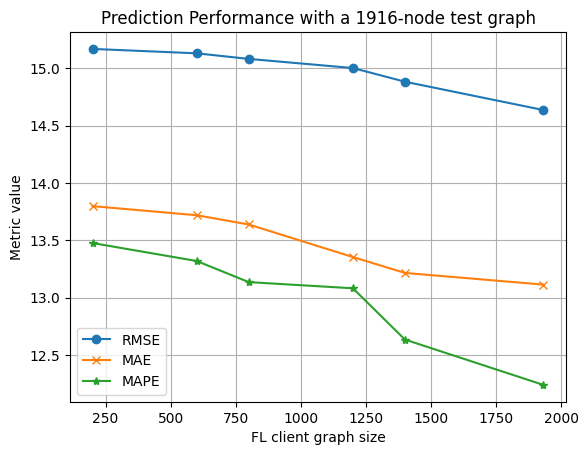

In [67]:
# num_change_arr=val_nodes

if not os.path.exists('RESULTS_mar6'):
    os.makedirs('RESULTS_mar6')
plt.figure(facecolor='white')
plt.title("Prediction Performance with a 1916-node test graph")
plt.xlabel("FL client graph size") 
plt.ylabel("Metric value") 
plt.plot(ratios, rmse_arr,'-o', label=("RMSE"))
plt.plot(ratios, mae_arr,'-x', label=("MAE"))
plt.plot(ratios, mape_arr,'-*', label=("MAPE"))
# plt.fill_between(num_change_arr, asr_lower, asr_upper, color='blue', alpha=0.2)

plt.grid()

plt.legend(title = str(94)+" adversary nodes")
plt.legend(loc='lower left')
# # plt.ylim(-0.1, 1)
# # plt.xlim(0, 500)
# x_ticks=num_change_arr
# x_labels = num_change_arr
# #add x-axis values to plot
# plt.xticks(ticks=x_ticks, labels=x_labels)
name='RESULTS_mar6/FL_test.png'
plt.savefig(name, dpi=150) 
name='RESULTS_mar6/FL_test.pdf'
plt.savefig(name, dpi=150) 

plt.show()